# Reddit Data Collection and Visualization

This notebook is designed to collect comments from a specified subreddit using Reddit's API through PRAW (Python Reddit API Wrapper). It filters out comments based on predefined blacklists and visualizes the data for insights.

## Features:
- Fetch comments from a chosen subreddit and filter ('top', 'hot', 'controversial').
- Exclude comments from blacklisted authors and comments with specific content (e.g., '[deleted]', '[removed]').
- Visualize the collected data for insights.

## Setup and Imports

Before running this notebook, ensure you have installed the necessary Python packages: `praw`, `pandas`, and any others required for your specific environment.


In [1]:
import praw
import pandas as pd

from datetime import datetime
from typing import TypedDict
import matplotlib.pyplot as plt

import prawcore
from prawcore.exceptions import Redirect, RequestException

from dotenv import load_dotenv
import os

from tqdm.auto import tqdm

/tmp/ipykernel_15696/4108803399.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Configuration

Set the target subreddit, and other configurations here.

In [2]:
# Subreddit configuration
SUBREDDIT_NAME = 'Philippines'
SUBREDDIT_FILTER = 'hot'
LIMIT = 10  # Adjust as needed, up to a maximum of 1000 due to Reddit's API limit

if not (1 <= LIMIT <= 1000):
    print("ERROR: Limit must be between 1 to 1000")
    exit()
if SUBREDDIT_FILTER not in ['hot', 'top', 'controversial']:
    print("ERROR: Subreddit filter must be 'hot', 'top', or 'controversial'")
    exit()

# Data filtering criteria
AUTHOR_DENYLIST = ['AutoModerator']
BODY_DENYLIST = ['[deleted]', '[removed]']

# Define options for subreddit fetching, mainly the limit
OPTIONS = {
    'limit': LIMIT,
}

# Constants for file naming
CURRENT_DATETIME = datetime.today().strftime("%Y%m%d-%H%M%S")   # Current date and time for filename
FILENAME = f'data-{SUBREDDIT_NAME}-{CURRENT_DATETIME}-{SUBREDDIT_FILTER}.csv'  # Filename format

## DataRow Definition

Define a structure for the data rows to ensure consistent data handling. We make a type for better clarity of the shape of the data being printed to the CSV.

In [3]:
class DataRow(TypedDict):
    body: str
    submission_name: str
    submission_text: str

## Data Collection & Execution

In this section, we will execute the data collection process which involves connecting to the Reddit API through PRAW (Python Reddit API Wrapper), fetching comments from the specified subreddit, and filtering the data based on predefined criteria. The final dataset will then be prepared for analysis and saved to a CSV file for further use.


In [4]:
# Load the .env file for reddit secrets
# Make sure to copy the file '.env.example' to '.env'
# and fill up the information there
if load_dotenv():
  print(".env loaded")
else:
  print("ERROR: Copy .env.example to .env and fill up the information")
  

.env loaded


In [5]:
# Initialize PRAW Reddit instance with credentials & user agent
reddit = praw.Reddit(
    client_id=os.getenv('REDDIT_CLIENT_ID'),
    client_secret=os.getenv('REDDIT_CLIENT_SECRET'),
    user_agent=os.getenv('REDDIT_USER_AGENT'),
    ratelimit_seconds=6000, # Give heavy allowance for rate limits to avoid TooManyRequests error
)

data_collection: list[DataRow] = [] # List to hold all DataRow items

reddit

In [6]:
# Get subreddit instance from PRAW
subreddit_instance = reddit.subreddit(SUBREDDIT_NAME)
subreddit_instance

Subreddit(display_name='Philippines')

In [7]:
# Select the subreddit section based on the filter argument (top, controversial, hot)
try:
    result = {
        'top': subreddit_instance.top(**OPTIONS),
        'controversial': subreddit_instance.controversial(**OPTIONS),
        'hot': subreddit_instance.hot(**OPTIONS),
    }[SUBREDDIT_FILTER]
except KeyError:
    print("ERROR: Please select 'hot', 'controversial', or 'top' for filter")
    exit(1)

### Data Gathering Loop

In [8]:
try:
    with tqdm(total=LIMIT, desc="POSTS") as progress_bar:
        for submission in result:   # Iterate through submissions in the selected subreddit section
            progress_bar.update(1)

            submission.comments.replace_more(limit=None)    # Load all comments by replacing "MoreComments"
            comments = submission.comments.list()   # Flatten the comment tree into a list

            for comment in tqdm(comments, desc="COMMENTS"):    # Iterate through each comment
                # Get author name, or set as empty string if not available
                author = (
                    comment.author.name 
                    if isinstance(comment.author, praw.models.Redditor) 
                    else ''
                )
                body = comment.body # Comment text
    
                # Skip comment if the author is in the blacklist
                if author in AUTHOR_DENYLIST: continue
    
                # Skip comment if body is in the blacklist
                if body in BODY_DENYLIST: continue
    
                data_row: DataRow = {
                    'submission_name': submission.title,
                    'submission_text': submission.selftext,
                    'body': body,
                }
                data_collection.append(data_row)    # Add the data row to the collection
except prawcore.exceptions.TooManyRequests:
    pass    # Handle rate limit exceptions gracefully
except Redirect:
    print("ERROR: Request redirected. Please check subreddit name and try again")
    exit(1)
except RequestException:
    print("ERROR: Request exception. Please check subreddit name and try again")
    exit(1)

print('Finished gathering data')

POSTS:   0%|          | 0/10 [00:00<?, ?it/s]

COMMENTS: 0it [00:00, ?it/s]

COMMENTS:   0%|          | 0/129 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/113 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/89 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/242 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/138 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/33 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/46 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/22 [00:00<?, ?it/s]

COMMENTS:   0%|          | 0/20 [00:00<?, ?it/s]

Finished gathering data


### Save the data

In [9]:
# Convert the list of DataRow dictionaries to a Pandas DataFrame
data_frame = pd.DataFrame(data_collection)

data_frame.to_csv(FILENAME, index=False) # Save the DataFrame to a CSV file

print(f"Saved as {FILENAME}")

Saved as data-Philippines-20240214-124912-hot.csv


## Data Visualization

Visualize the collected data to gain insights, such as the number of comments per post.

In [10]:
# Show the table

data_frame.head()

,submission_name,submission_text,body
0,"Weekly help thread - Feb 12, 2024",Need help on something? Whether it's about hea...,What time po nagbubukas ang dangwa? Thanks po ...
1,"Weekly help thread - Feb 12, 2024",Need help on something? Whether it's about hea...,Hello pwede bang blangko muna petsa sa itinera...
2,"Weekly help thread - Feb 12, 2024",Need help on something? Whether it's about hea...,Good Day! help lang po for tips. I am starting...
3,"Weekly help thread - Feb 12, 2024",Need help on something? Whether it's about hea...,How do you folks find room for rent na solo mo...
4,"Weekly help thread - Feb 12, 2024",Need help on something? Whether it's about hea...,Pano po umorder ng cake sa California


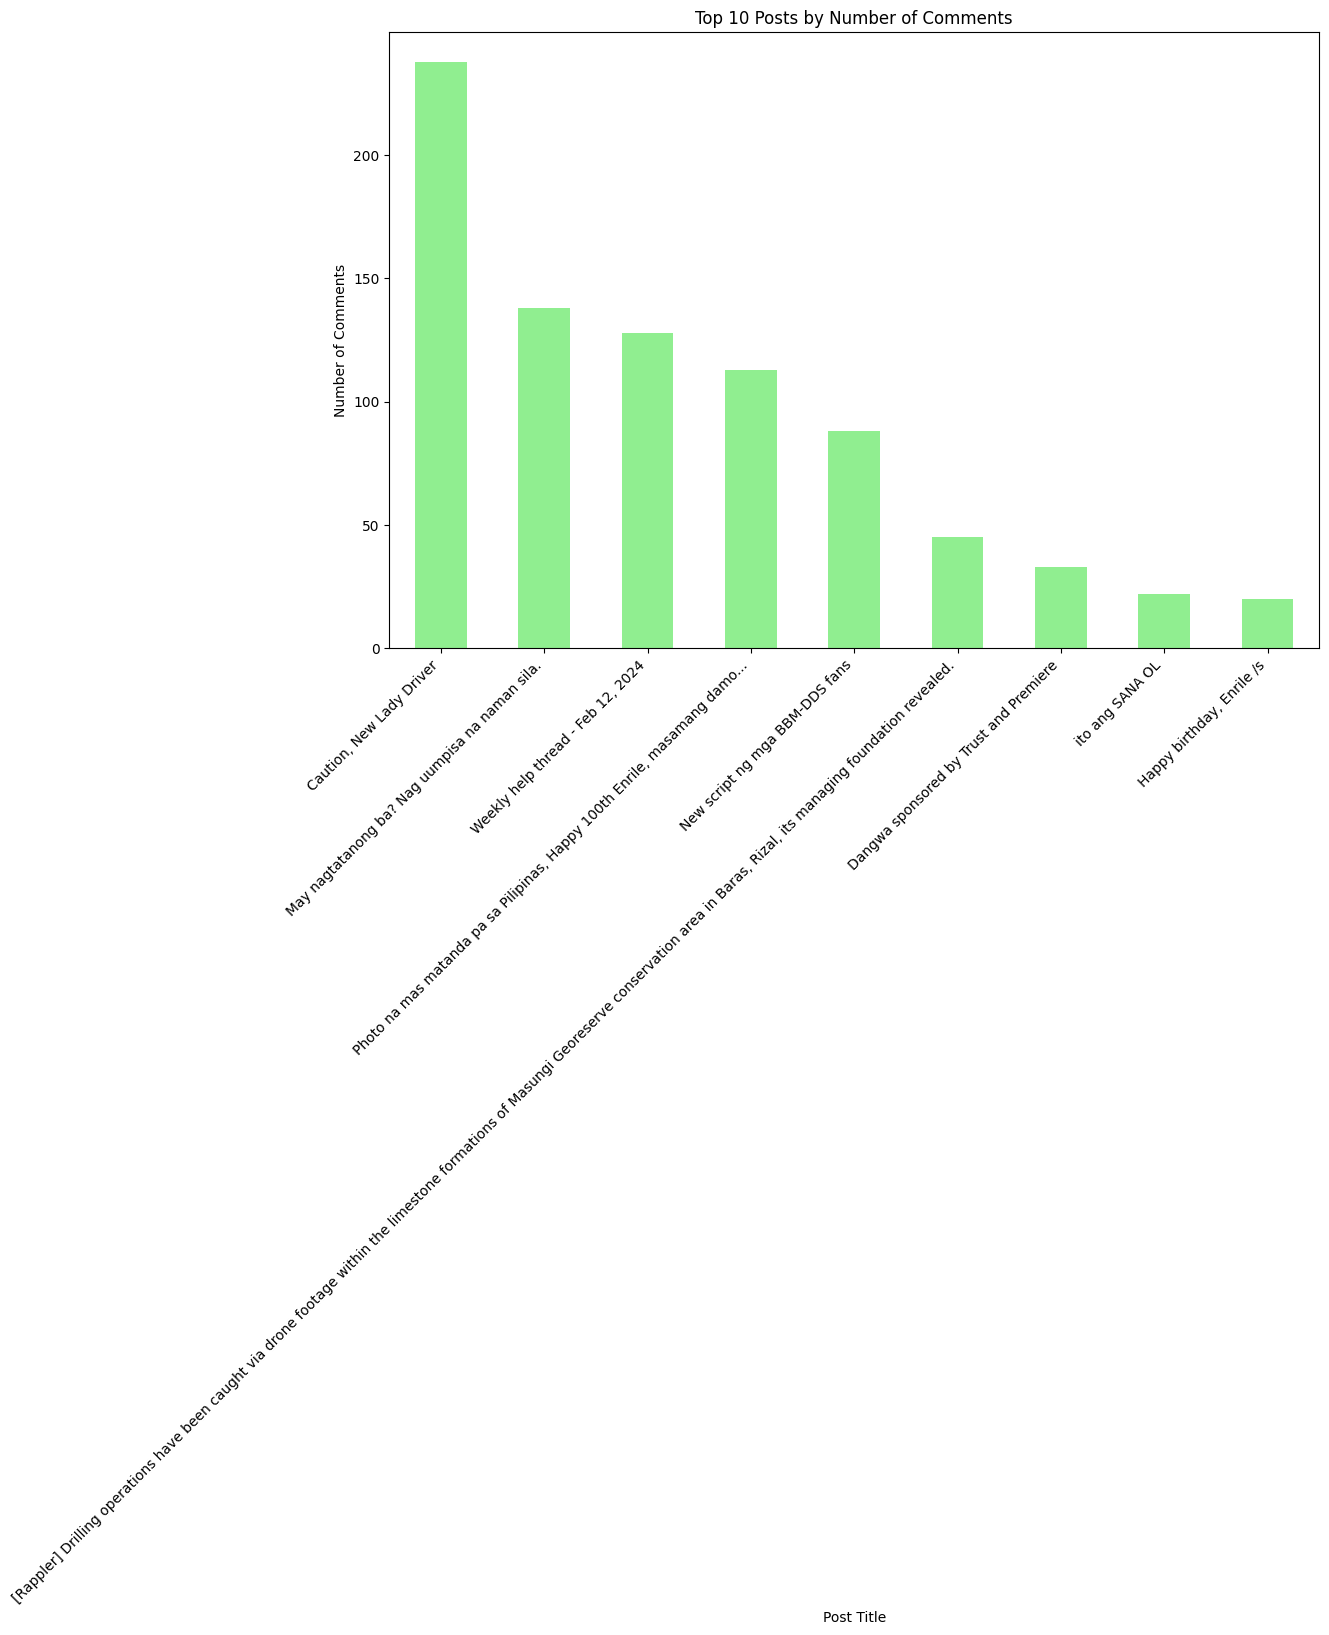

In [11]:
# Group the data by submission_name and count the number of comments for each post
# Use 'body' column for counting since every comment should have a body
comments_per_post = data_frame.groupby('submission_name')['body'].count()

# Sorting the counts and selecting the top N posts for better visibility in the bar chart
top_comments_per_post = comments_per_post.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
top_comments_per_post.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Posts by Number of Comments')
plt.xlabel('Post Title')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')  # Rotate post titles for better readability
plt.show()

In [12]:
# Group the data by 'submission_name' and count the number of comments for each post
comments_per_post = data_frame.groupby('submission_name')['body'].count().sort_values(ascending=False)

# Convert the Series object to DataFrame for better readability
comments_per_post_df = comments_per_post.to_frame(name='Number of Comments')

# Resetting the index to have 'submission_name' as a column instead of an index
comments_per_post_df.reset_index(inplace=True)

# Optionally, rename the columns for better readability
comments_per_post_df.columns = ['Post Title', 'Number of Comments']

# Display the DataFrame
comments_per_post_df

,Post Title,Number of Comments
0,"Caution, New Lady Driver",238
1,May nagtatanong ba? Nag uumpisa na naman sila.,138
2,"Weekly help thread - Feb 12, 2024",128
3,"Photo na mas matanda pa sa Pilipinas, Happy 10...",113
4,New script ng mga BBM-DDS fans,88
5,[Rappler] Drilling operations have been caught...,45
6,Dangwa sponsored by Trust and Premiere,33
7,ito ang SANA OL,22
8,"Happy birthday, Enrile /s",20


In [13]:
# Count the number of non-NA/null entries in the 'body' column
total_comments = data_frame['body'].count()  
print(f"Total number of comments: {total_comments}")

Total number of comments: 825
